! uv pip install jax[cuda12] --force-reinstall
# Imports

In [1]:
import mmml
import ase
import os
from pathlib import Path
# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
import jax
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())


[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


In [2]:
import os, jax, jax.numpy as jnp
print("LD_LIBRARY_PATH:", os.environ.get("LD_LIBRARY_PATH"))
x = jnp.ones((1024,1024), dtype=jnp.float32)
y = jnp.ones((1024,1024), dtype=jnp.float32)
print((x@y).block_until_ready().shape)

LD_LIBRARY_PATH: None
(1024, 1024)


In [3]:
from mmml.physnetjax import *

In [4]:
from mmml.physnetjax.physnetjax.calc.helper_mlp import get_ase_calc


In [5]:
?get_ase_calc

Signature:
get_ase_calc(
    params,
    model,
    ase_mol,
    conversion={'energy': 1, 'forces': 1, 'dipole': 1},
    implemented_properties=['energy', 'forces', 'dipole'],
)
Docstring:
Ase calculator implementation for physnetjax model

Args:
params: params of the physnetjax model
model: physnetjax model
ase_mol: ase molecule
conversion: conversion factor for the energy, forces, and dipole
implemented_properties: implemented properties for the ase calculator

Returns:
Ase calculator implementation for physnetjax model
File:      ~/mmml/mmml/physnetjax/physnetjax/calc/helper_mlp.py
Type:      function

In [6]:
from mmml.physnetjax.physnetjax.models import model as model
from mmml.physnetjax.physnetjax.models.model import EF
from mmml.physnetjax.physnetjax.training.training import train_model


# Data

In [7]:
from mmml.physnetjax.physnetjax.data.data import prepare_datasets
from mmml.physnetjax.physnetjax.data.batches import prepare_batches_jit

In [8]:
?prepare_datasets

Signature:
prepare_datasets(
    key,
    train_size=0,
    valid_size=0,
    files=None,
    clean=False,
    esp_mask=False,
    clip_esp=False,
    natoms=60,
    verbose=False,
    subtract_atom_energies=False,
    subtract_mean=False,
)
Docstring:
Prepare datasets for training and validation.

Args:
    key: Random key for dataset shuffling.
    num_train (int): Number of training samples.
    num_valid (int): Number of validation samples.
    filename (str or list): Filename(s) to load datasets from.

Returns:
    tuple: A tuple containing train_data and valid_data dictionaries.
File:      ~/mmml/mmml/physnetjax/physnetjax/data/data.py
Type:      function

In [9]:
jax.random.key(1)

Array((), dtype=key<fry>) overlaying:
Array[2] u32 μ=0.500 σ=0.500 gpu:0 [0, 1]

In [10]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(42), 2)
BATCHSIZE = 16

In [11]:
data_paths = list(Path("/scicore/home/meuwly/boitti0000/").glob("b*npz"))
data_paths

[Path('/scicore/home/meuwly/boitti0000/beta-diketones_71208.npz')]

In [12]:
import numpy as np
np.load(data_paths[0])["Z"]

array([[6, 6, 1, ..., 0, 0, 0],
       [6, 6, 1, ..., 1, 0, 0],
       [6, 6, 6, ..., 0, 0, 0],
       ...,
       [8, 6, 6, ..., 0, 0, 0],
       [6, 6, 6, ..., 0, 0, 0],
       [8, 6, 6, ..., 0, 0, 0]], shape=(71208, 17))

In [13]:
71208 * .2

14241.6

In [14]:
BATCHSIZE

16

In [15]:
files = data_paths
train_size = 59000 
valid_size = 1400
NATOMSMAX = 17

train_data, valid_data = prepare_datasets(data_key, train_size, valid_size, files, natoms=NATOMSMAX)

dataR (71208, 17, 3)
dataE [-54.02564528 -60.37702056 -34.56810181 -34.74576462 -41.01765859
 -40.48231955 -53.06176803 -35.04941783 -27.50888271 -40.22177633]
dataE [-54.02564528 -60.37702056 -34.56810181 -34.74576462 -41.01765859
 -40.48231955 -53.06176803 -35.04941783 -27.50888271 -40.22177633]
D (71208, 3)
Q 1 (71208,) 71208
Q (71208,)


In [16]:
?EF

Init signature:
EF(
    features: int = 32,
    max_degree: int = 3,
    num_iterations: int = 2,
    num_basis_functions: int = 16,
    cutoff: float = 6.0,
    max_atomic_number: int = 118,
    charges: bool = False,
    natoms: int = 60,
    total_charge: float = 0,
    n_res: int = 3,
    zbl: bool = True,
    debug: Union[bool, List[str]] = False,
    efa: bool = False,
    use_energy_bias: bool = True,
    parent: Union[flax.linen.module.Module, flax.core.scope.Scope, flax.linen.module._Sentinel, NoneType] = <flax.linen.module._Sentinel object at 0x14881447bf20>,
    name: Optional[str] = None,
) -> None
Docstring:     
Energy and Forces Neural Network Model.

A neural network model that predicts molecular energies and forces using message passing
and equivariant transformations.

Attributes:
    features: Number of features in the neural network layers
    max_degree: Maximum degree for spherical harmonics
    num_iterations: Number of message passing iterations
    num_basis_fu

In [17]:
valid_batches = prepare_batches_jit(data_key, valid_data, BATCHSIZE, num_atoms = NATOMSMAX)

In [18]:
model = EF(
    features=32,
    max_degree = 1,
    num_basis_functions=32,
    num_iterations = 2,
    n_res=4,
    cutoff = 8.0,
    max_atomic_number = 40,
    zbl=False,
    efa=False,
    charges=True,
)
model

EF(
    # attributes
    features = 32
    max_degree = 1
    num_iterations = 2
    num_basis_functions = 32
    cutoff = 8.0
    max_atomic_number = 40
    charges = True
    natoms = 60
    total_charge = 0
    n_res = 4
    zbl = False
    debug = False
    efa = False
    use_energy_bias = True
)

## Training

In [19]:
uid = "test-84aa02d9-e329-46c4-b12c-f55e6c9a2f94"
SCICORE = Path('/scicore/home/meuwly/boitti0000/ckpts')
RESTART=str(SCICORE / f"{uid}")
params_out = train_model(
    train_key,
    model,
    train_data,
    valid_data, 
    num_epochs = 6300,
    learning_rate=0.0005,
    batch_size=BATCHSIZE,
    num_atoms=NATOMSMAX,
    energy_weight=100,
    restart=RESTART,
    conversion={'energy': 1, 'forces': 1},
    print_freq=1,
    name='test',
    best=False,
    optimizer=None,
    transform=None,
    schedule_fn="constant",
    objective='valid_loss',
    ckpt_dir=SCICORE,
    log_tb=False,
    batch_method="default",
    batch_args_dict=None,
    data_keys=('R', 'Z', 'F', "N", 'E', 'D', 'batch_segments'),
    
)

                                            Train Data                                             
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ R              ┃ Z           ┃ F              ┃ E          ┃ N          ┃ D          ┃ Q        ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━┩
│ (59000, 17, 3) │ (59000, 17) │ (59000, 17, 3) │ (59000, 1) │ (59000, 1) │ (59000, 3) │ (59000,) │
└────────────────┴─────────────┴────────────────┴────────────┴────────────┴────────────┴──────────┘

                                      Validation Data                                       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┓
┃ R             ┃ Z          ┃ F             ┃ E         ┃ N         ┃ D         ┃ Q       ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━┩
│ (1400, 17, 3) │ (1400, 17) │ (1400, 17, 3) │ (1400, 1) │ (1400, 1) │ (1400, 3) │ (1400,) │
└───────────────┴────────────┴───────────────┴───────────┴───────────┴───────────┴─────────┘

Using default (fat) batching method


Training Routine

.,,uod8B8bou,,.
              ..,uod8BBBBBBBBBBBBBBBBRPFT?l!i:.
         ,=m8BBBBBBBBBBBBBBBRPFT?!||||||||||||||
         !...:!TVBBBRPFT||||||||||!!^^""'   ||||
         !.......:!?|||||!!^^""'            ||||
         !.........||||                     ||||
         !.........||||  ##                 ||||
         !.........||||      PhysNet        ||||
         !.........||||      JAX            ||||
         !.........||||                     ||||
         !.........||||                     ||||
         `.........||||                    ,||||
          .;.......||||               _.-!!|||||
   .,uodWBBBBb.....||||       _.-!!|||||||||!:'
!YBBBBBBBBBBBBBBb..!|||:..-!!|||||||!iof68BBBBBb....
!..YBBBBBBBBBBBBBBb!!||||||||!iof68BBBBBBRPFT?!::   `.
!....YBBBBBBBBBBBBBBbaaitf68BBBBBBRPFT?!:::::::::     `.
!......YBBBBBBBBBBBBBBBBBBBRPFT?!::::::;:!^"`;:::       `.
!........YBBBBBBBBBBRPFT?!::::::::::^''...::::::;         iBBbo.
`..........YBRPFT?!::::::::::::::::::::::::;iof68bo.      WBBBBbo.
  `..........:::::::::::::::::::::::;iof688888888888b.     `YBBBP^'
    `........::::::::::::::::;iof688888888888888888888b.     `
      `......:::::::::;iof688888888888888888888888888888b.
        `....:::;iof688888888888888888888888888888888899fT!
          `..::!8888888888888888888888888888888899fT|!^"'
            `' !!988888888888888888888888899fT|!^"'
                `!!8888888888888888899fT|!^"'
                  `!988888888899fT|!^"'
                    `!9899fT|!^"'
                      `!^"'

DATA_PATH: /scicore/home/meuwly/boitti0000/mmml/mmml/physnetjax/data

LOGS_PATH: /scicore/home/meuwly/boitti0000/mmml/mmml/physnetjax/logs

ANALYSIS_PATH: /scicore/home/meuwly/boitti0000/mmml/mmml/physnetjax/analysis

MAIN_PATH: /scicore/home/meuwly/boitti0000/mmml/mmml/physnetjax

PYCHARMM_DIR: None

Start Time:  12:40:35

                                                Optimizer Arguments                                                
┏━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━┳━━━━━━┳━━━━━━━┓
┃ optimizer ┃ optimized_… ┃ schedule_fn ┃ scheduling… ┃ transform ┃ reduce_tra… ┃ clip_glob… ┃ b1  ┃ b2   ┃ eps   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━╇━━━━━━╇━━━━━━━┩
│ None      │ GradientTr… │ constant    │ <function   │ None      │ GradientTr… │ 10.0       │ 0.9 │ 0.99 │ 0.001 │
│           │ chain.<loc… │             │ constant_s… │           │ reduce_on_… │            │     │      │       │
│           │ at          │             │ at          │           │ at          │            │     │      │       │
│           │ 0x1487f955… │             │ 0x1487faf7… │           │ 0x1487f955… │            │     │      │       │
│           │ update=<fu… │             │             │           │ update=<fu… │            │     │      │       │
│           │ chain.<loc… │             │             │           │ reduce_on_… │            │     │      │       │
│           │ at          │             │             │           │ at          │            │     │      │       │
│           │ 0x1487f955… │             │             │           │ 0x1487f955… │            │     │      │       │
└───────────┴─────────────┴─────────────┴─────────────┴───────────┴─────────────┴────────────┴─────┴──────┴───────┘

                                    Training Parameters                                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ energy_weight ┃ forces_weight ┃ dipole_weight ┃ charges_weight ┃ batch_size ┃ num_atoms ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ 100           │ 52.91         │ 27.21         │ 14.39          │ 16         │ 17        │
└───────────────┴───────────────┴───────────────┴────────────────┴────────────┴───────────┘

                                                  Training Style                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ restart                                      ┃ best  ┃ data_keys                                   ┃ objective  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ /scicore/home/meuwly/boitti0000/ckpts/test-… │ False │ ('R', 'Z', 'F', 'N', 'E', 'D',              │ valid_loss │
│                                              │       │ 'batch_segments')                           │            │
└──────────────────────────────────────────────┴───────┴─────────────────────────────────────────────┴────────────┘

                                                Validation Batch[0]                                                
┏━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ R        ┃ Z      ┃ F        ┃ N     ┃ E       ┃ D       ┃ dst_idx ┃ src_idx ┃ batch_ma… ┃ batch_se… ┃ atom_ma… ┃
┡━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ (272, 3) │ (272,) │ (272, 3) │ (16,) │ (16, 1) │ (16, 3) │ (4352,) │ (4352,) │ (4352,)   │ (272,)    │ (272,)   │
└──────────┴────────┴──────────┴───────┴─────────┴─────────┴─────────┴─────────┴───────────┴───────────┴──────────┘

Extra Validation Info:
Z: Array[1400, 17] i32 n=23800 (93Kb) x∈[0, 8] μ=2.022 σ=2.707 cpu:0
R: Array[1400, 17, 3] n=71400 (0.3Mb) x∈[-3.429, 3.382] μ=0.004 σ=0.894 cpu:0
E: Array[1400, 1] 5.5Kb x∈[-67.615, -9.490] μ=-42.597 σ=13.520 cpu:0
N: Array[1400, 1] i32 5.5Kb x∈[3, 17] μ=10.344 σ=3.098 cpu:0
F: Array[1400, 17, 3] n=71400 (0.3Mb) x∈[-11.194, 11.759] μ=-2.838e-10 σ=1.317 cpu:0
D: Array[1400, 3] n=4200 (16Kb) x∈[-1.076, 0.854] μ=-0.010 σ=0.272 cpu:0


ERROR:asyncio:Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/scicore/home/meuwly/boitti0000/.conda/envs/mmml-gpu/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x14949e83bb40> is already entered
ERROR:asyncio:Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/scicore/home/meuwly/boitti0000/.conda/envs/mmml-gpu/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x14949e83bb40> is already entered
ERROR:asyncio:Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/scicore/home/meuwly/boitti0000/.conda/envs/mmml-gpu/lib/python3.12/asyncio/events.py", line 88, in _run
    s

dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ char… ┃ cuto… ┃ debug ┃ efa   ┃ feat… ┃ max_… ┃ max_… ┃ n_res ┃ nato… ┃ num_b… ┃ num_… ┃ total… ┃ use_… ┃ zbl   ┃
┡━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ True  │ 8.0   │ False │ False │ 32    │ 40    │ 1     │ 4     │ 17    │ 32     │ 2     │ 0      │ True  │ False │
└───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴────────┴───────┴────────┴───────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                              ┃ name       ┃ epoch ┃ best_loss           ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /scicore/home/meuwly/boitti0000/ckpts/… │ epoch-5209 │ 5209  │ Array gpu:0 146.001 │ 2025-11-18 13:38:07.505522 │
└─────────────────────────────────────────┴────────────┴───────┴─────────────────────┴────────────────────────────┘

ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-168' coro=<_async_in_context.<locals>.run_in_context() running at /scicore/home/meuwly/boitti0000/.local/lib/python3.12/site-packages/ipykernel/utils.py:60> wait_for=<Task pending name='Task-2' coro=<Kernel.shell_main() running at /scicore/home/meuwly/boitti0000/.local/lib/python3.12/site-packages/ipykernel/kernelbase.py:590> cb=[Task.task_wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /scicore/home/meuwly/boitti0000/.local/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>
ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-2' coro=<Kernel.shell_main() running at /scicore/home/meuwly/boitti0000/.local/lib/python3.12/site-packages/ipykernel/kernelbase.py:590> cb=[Task.task_wakeup()]>
ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-25' coro=<Kernel.shell_main() running at /scicore/home/meuwly/boitti0000/.local/li

Restoring from /scicore/home/meuwly/boitti0000/ckpts/test-84aa02d9-e329-46c4-b12c-f55e6c9a2f94/epoch-5209
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
Training resumed from step 5209, best_loss Array gpu:0 146.001


                                                                                Model Attributes                                                                                 
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ features ┃ max_degree ┃ num_iterations ┃ num_basis_functions ┃ cutoff ┃ max_atomic_number ┃ charges ┃ natoms ┃ total_charge ┃ n_res ┃ zbl   ┃ debug ┃ efa   ┃ use_energy_bias ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 32       │ 1          │ 2              │ 32                  │ 8.0    │ 40                │ True    │ 17     │ 0            │ 4     │ False │ False │ False │ True            │
└──────────┴────────────┴────────────────┴─────────────────────┴────────┴───────────────────┴─────────┴────────┴──────────────┴───────┴───────┴───────┴───────┴─────────────────┘

Output()

ERROR:asyncio:Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/scicore/home/meuwly/boitti0000/.conda/envs/mmml-gpu/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x14949e83bb40> is already entered
ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-2842' coro=<_async_in_context.<locals>.run_in_context() done, defined at /scicore/home/meuwly/boitti0000/.local/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-2843' coro=<Kernel.shell_main() running at /scicore/home/meuwly/boitti0000/.local/lib/python3.12/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /scicore/home/meuwly/boitti0000/.local/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>
ERROR:asyncio:Task w


KeyboardInterrupt



In [22]:
from mmml.physnetjax.physnetjax.restart.restart import get_last, get_params_model, get_params_model_with_ase

In [24]:
uid = "test-84aa02d9-e329-46c4-b12c-f55e6c9a2f94"
SCICORE = Path('/scicore/home/meuwly/boitti0000/ckpts')
RESTART=str(SCICORE / f"{uid}")
RESTART

'/scicore/home/meuwly/boitti0000/ckpts/test-84aa02d9-e329-46c4-b12c-f55e6c9a2f94'

In [25]:
last= get_last(RESTART)
last 

Path('/scicore/home/meuwly/boitti0000/ckpts/test-84aa02d9-e329-46c4-b12c-f55e6c9a2f94/epoch-5450')

In [31]:
N = valid_batches[0]["N"][0]
R = valid_batches[0]["R"][:N]
Z = valid_batches[0]["Z"][:N]
atoms=ase.Atoms(Z , R)
atoms

Atoms(symbols='OH2', pbc=False)

In [39]:
params, model, everything = get_params_model(last, return_everything=True)
params, model, everything

dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ char… ┃ cuto… ┃ debug ┃ efa   ┃ feat… ┃ max_… ┃ max_… ┃ n_res ┃ nato… ┃ num_b… ┃ num_… ┃ total… ┃ use_… ┃ zbl   ┃
┡━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ True  │ 8.0   │ False │ False │ 32    │ 40    │ 1     │ 4     │ 17    │ 32     │ 2     │ 0      │ True  │ False │
└───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴────────┴───────┴────────┴───────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /scicore/home/meuwly/boitti0000/ckpts/te… │ epoch-5450 │ 5450  │ Array gpu:0 2.792 │ 2025-11-18 15:06:17.241811 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

({'params': {'Dense_0': {'0+': {'bias': Array[32] x∈[-0.990, 0.520] μ=-0.052 σ=0.341 gpu:0,
     'kernel': Array[32, 32] n=1024 (4Kb) x∈[-1.076, 0.934] μ=0.003 σ=0.283 gpu:0},
    '1-': {'kernel': Array[32, 32] n=1024 (4Kb) x∈[-0.866, 1.235] μ=-0.003 σ=0.265 gpu:0}},
   'Dense_1': {'0+': {'bias': Array[32] x∈[-0.574, 0.438] μ=-0.008 σ=0.261 gpu:0,
     'kernel': Array[32, 32] n=1024 (4Kb) x∈[-0.837, 0.704] μ=-0.009 σ=0.240 gpu:0},
    '1-': {'kernel': Array[32, 32] n=1024 (4Kb) x∈[-0.989, 0.734] μ=-0.010 σ=0.244 gpu:0}},
   'Dense_10': {'0+': {'kernel': Array[32, 1] x∈[-0.319, 1.669] μ=0.120 σ=0.366 gpu:0}},
   'Dense_11': {'kernel': Array[1, 1] gpu:0 [[-0.083]]},
   'Dense_12': {'0+': {'kernel': Array[32, 1] x∈[-0.311, 0.879] μ=0.068 σ=0.250 gpu:0}},
   'Dense_13': {'kernel': Array[1, 1] gpu:0 [[0.019]]},
   'Dense_2': {'0+': {'bias': Array[32] x∈[-0.738, 0.335] μ=-0.061 σ=0.320 gpu:0,
     'kernel': Array[32, 32] n=1024 (4Kb) x∈[-0.826, 0.655] μ=-0.034 σ=0.221 gpu:0},
    '1-': {'ker

In [32]:
get_params_model_with_ase?

Signature: get_params_model_with_ase(pkl_path, model_path, atoms)
Docstring:
Load parameters and model from pickle files with ASE atoms.

Parameters
----------
pkl_path : str
    Path to parameters pickle file
model_path : str
    Path to model configuration pickle file
atoms : ase.Atoms
    ASE atoms object
    
Returns
-------
tuple
    Tuple of (parameters, model)
File:      ~/mmml/mmml/physnetjax/physnetjax/restart/restart.py
Type:      function

# Validation

In [43]:
from mmml.physnetjax.physnetjax.analysis.analysis import  *
model.natoms = 17
output = mmml.physnetjax.physnetjax.analysis.analysis.eval(valid_batches, model, params, batch_size=BATCHSIZE)
Es, Eeles, predEs, Fs, predFs, Ds, predDs, charges, outputs = output


87it [01:03,  1.38it/s]


In [50]:
ase_kcalmol = ase.units.kcal/ase.units.mol
1/ase_kcalmol

23.060548012069496

[np.float64(-67.61493225251813),
 np.float64(-61.802418844991635),
 np.float64(-29.833595103595925),
 np.float64(-18.208568288542942),
 np.float64(-9.489798177253208)]

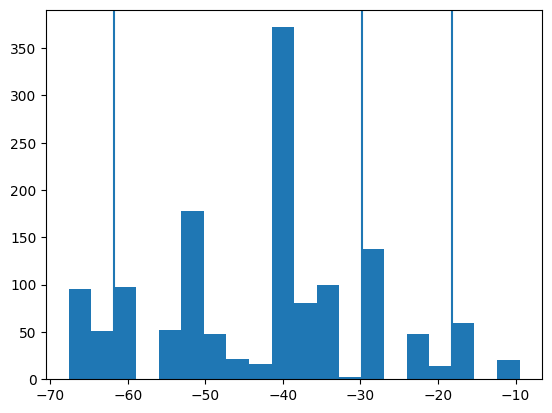

In [79]:
bin_count_edges = plt.hist(Es, bins=20)
bins = [bin_count_edges[1][0]]
for i, _ in enumerate(bin_count_edges[0]):
    if _ == 0:
        bins.append(bin_count_edges[1][i-1])
        plt.axvline(bins[-1])
bins.append(bin_count_edges[1][-1])
bins
    

In [80]:
len(bins)

5

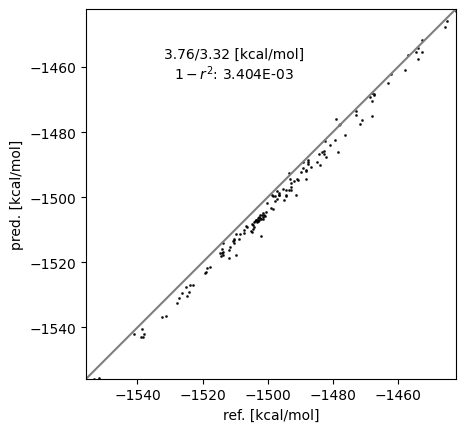

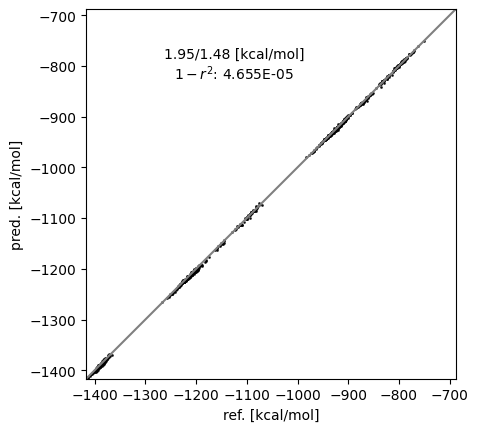

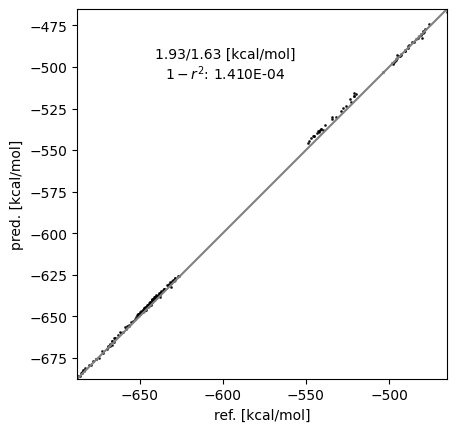

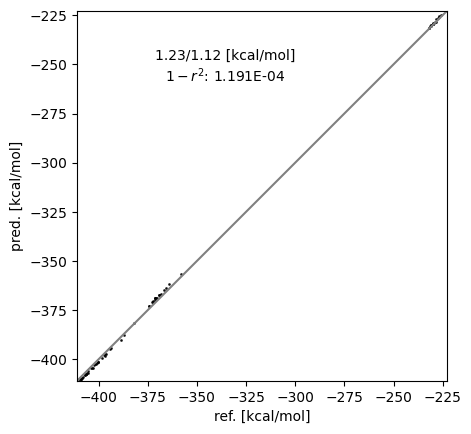

In [81]:
for i in range(len(bins)-1):
    monomers_idx = (Es < bins[1+i]) * (Es > bins[i])
    # dimers_idx = Es < bins[1]
    ax = plt.gca()
    plot(Es[monomers_idx]/ase_kcalmol, predEs[monomers_idx]/ase_kcalmol, ax, units="kcal/mol", _property="", kde=False, s=1, diag=True)
    # plt.xlim(-42, -40)
    # plt.ylim(-42, -40)
    plt.show()
    # ax = plt.gca()
    # plot(Es[dimers_idx]/ase_kcalmol, predEs[dimers_idx]/ase_kcalmol, ax, units="kcal/mol", _property="", kde=False, s=1, diag=True)

<Axes: xlabel='ref. [kcal/mol]', ylabel='pred. [kcal/mol]'>

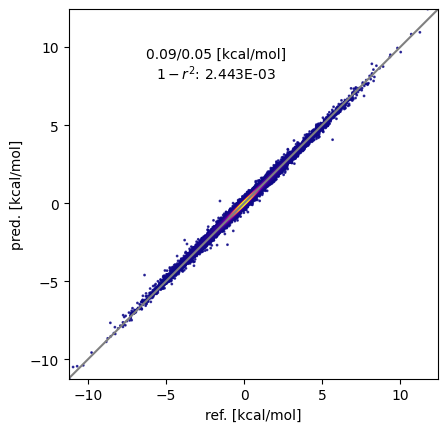

In [82]:
ax = plt.gca()
plot(Fs, predFs, ax, units="kcal/mol", _property="", kde=True, s=1, diag=True)

# Calculator

In [109]:
# !conda install pint
from mmml.pycharmmInterface import import_pycharmm
import pycharmm
from mmml.pycharmmInterface.mmml_calculator import setup_calculator, CutoffParameters

In [110]:
?CutoffParameters

Init signature:
CutoffParameters(
    ml_cutoff: 'float' = 2.0,
    mm_switch_on: 'float' = 5.0,
    mm_cutoff: 'float' = 1.0,
)
Docstring:      Parameters for ML and MM cutoffs and switching functions
Init docstring:
Args:
    ml_cutoff: Distance where ML potential is cut off
    mm_switch_on: Distance where MM potential starts switching on
    mm_cutoff: Final cutoff for MM potential
File:           ~/mmml/mmml/pycharmmInterface/mmml_calculator.py
Type:           type
Subclasses:     

In [111]:
ATOMS_PER_MONOMER = 10
N_MONOMERS = 2

In [112]:
?setup_calculator

Signature:
setup_calculator(
    ATOMS_PER_MONOMER,
    N_MONOMERS: 'int' = 2,
    ml_cutoff_distance: 'float' = 2.0,
    mm_switch_on: 'float' = 5.0,
    mm_cutoff: 'float' = 1.0,
    doML: 'bool' = True,
    doMM: 'bool' = True,
    doML_dimer: 'bool' = True,
    debug: 'bool' = False,
    ep_scale=None,
    sig_scale=None,
    model_restart_path=None,
    MAX_ATOMS_PER_SYSTEM=100,
    ml_energy_conversion_factor: 'float' = 23.060548012069496,
    ml_force_conversion_factor: 'float' = 23.060548012069496,
    cell=False,
    verbose: 'bool' = False,
)
Docstring: <no docstring>
File:      ~/mmml/mmml/pycharmmInterface/mmml_calculator.py
Type:      function

In [114]:
calculator_factory = setup_calculator(
    ATOMS_PER_MONOMER,
    N_MONOMERS,
    ml_cutoff_distance  = 2.0,
    mm_switch_on = 4.0,
    mm_cutoff  = 1.0,
    doML = True,
    doMM  = True,
    doML_dimer  = True,
    debug  = False,
    ep_scale = None,
    sig_scale = None,
    model_restart_path = RESTART,
    MAX_ATOMS_PER_SYSTEM = 20,
)

[setup_calculator] Cutoff inputs -> ml_cutoff_distance=2.0000, mm_switch_on=4.0000, mm_cutoff=1.0000
[setup_calculator] CutoffParameters stored -> ml_cutoff=2.0000, mm_switch_on=4.0000, mm_cutoff=1.0000
0 1
unique_res_ids [0, 1]
len(dimer_perms) 1


/scicore/home/meuwly/boitti0000/.local/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1345: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ char… ┃ cuto… ┃ debug ┃ efa   ┃ feat… ┃ max_… ┃ max_… ┃ n_res ┃ nato… ┃ num_b… ┃ num_… ┃ total… ┃ use_… ┃ zbl   ┃
┡━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ True  │ 8.0   │ False │ False │ 32    │ 40    │ 1     │ 4     │ 17    │ 32     │ 2     │ 0      │ True  │ False │
└───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴────────┴───────┴────────┴───────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /scicore/home/meuwly/boitti0000/ckpts/te… │ epoch-5450 │ 5450  │ Array gpu:0 2.792 │ 2025-11-18 15:06:17.241811 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

In [115]:
from ase.visualize.plot import plot_atoms
from mmml.pycharmmInterface import import_pycharmm
from mmml.pycharmmInterface.import_pycharmm import  *

In [117]:
# from mmml.pycharmmInterface import setupRes, setupBox
from mmml.pycharmmInterface.import_pycharmm import reset_block, reset_block_no_internal
from mmml.pycharmmInterface.pycharmmCommands import CLEAR_CHARMM

In [118]:
CLEAR_CHARMM()
reset_block()
reset_block_no_internal()
reset_block()
reset_block()
reset_block_no_internal()
reset_block()

  
 CHARMM>     DELETE ATOM SELE ALL END
  
  
 CHARMM>     DELETE PSF SELE ALL END
  
  
 CHARMM>     BLOCK
  
  BLOCK>            CALL 1 SELE ALL END
 SELRPN>      0 atoms have been selected out of      0
 The selected atoms have been reassigned to block   1
  
  BLOCK>              COEFF 1 1 1.0
  
  BLOCK>            END
 Matrix of Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of BOND Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ANGLE Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of DIHE Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of CROSS Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ELEC Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of VDW Interac

In [119]:
initialize_psf("ACO", 2, 30, None)

NameError: name 'initialize_psf' is not defined

In [93]:
# mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [94]:
energy.show()

NameError: name 'energy' is not defined

In [95]:
ase_atoms = ase_from_pycharmm_state()
R = ase_atoms.get_positions()
Z = ase_atoms.get_atomic_numbers()
R,Z

NameError: name 'ase_from_pycharmm_state' is not defined

In [96]:
FACTOR = 1/(ase.units.kcal/ase.units.mol)
calcs = calculator_factory(atomic_numbers=Z, atomic_positions=R, n_monomers=2,
                           energy_conversion_factor=FACTOR, force_conversion_factor=FACTOR, 
                           debug=False
                          )

NameError: name 'calculator_factory' is not defined

In [97]:
ase_atoms.calc = calcs[0]

NameError: name 'calcs' is not defined

In [98]:
ase_atoms.get_potential_energy()

NameError: name 'ase_atoms' is not defined

In [99]:
pycharmm_quiet()
pycharmm_verbose()

NameError: name 'pycharmm_quiet' is not defined

In [100]:
fix_idxs = np.array(range(20))
_fix_idxs = np.array(range(20))
fix_idxs[0] = _fix_idxs[3]
fix_idxs[3] = _fix_idxs[0]
fix_idxs[10] = _fix_idxs[13]
fix_idxs[13] = _fix_idxs[10]
batch_index = 0

In [101]:
test_R = valid_batches[batch_index]["R"][:20][fix_idxs]

In [102]:
test_Z = valid_batches[batch_index]["Z"][:20]
test_Z, test_Z[fix_idxs]

(array([8, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 6, 6]),
 array([0, 1, 1, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 6, 6]))

In [ ]:
model.natoms = 20
model

In [ ]:
ref_physnet_atoms = ase.Atoms(test_Z[fix_idxs], test_R)
ref_physnet_atoms.calc = get_ase_calc(params_out, model, ref_physnet_atoms, {"energy": 1, "forces": 1}, ['energy', 'forces'])

In [ ]:
ref_physnet_atoms.get_potential_energy()

In [ ]:
ref_physnet_F = ref_physnet_atoms.get_forces().flatten()

In [ ]:
ref_e = valid_batches[batch_index]["E"][0][0]
ref_e

In [ ]:
ref_f = valid_batches[batch_index]["F"][:20]
refF = ref_f.flatten()

In [ ]:
ase_atoms.set_positions(test_R)

In [ ]:
ase_atoms.get_atomic_numbers()

In [ ]:
ase_atoms.get_potential_energy()

In [ ]:
mF = np.array(ase_atoms.get_forces()).flatten()

In [ ]:
ks = [
 'dH',
 'energy',
 'forces',
 'internal_E',
 'internal_F',
 'ml_2b_E',
 'ml_2b_F',
 'mm_E',
 'mm_F']
di = {}
for k in ks:
    di[k] = dict(ase_atoms.calc.results)["out"].__getattribute__(k).flatten()

In [ ]:
dir(dict(ase_atoms.calc.results)["out"])
di

In [ ]:
view_atoms(ref_physnet_atoms)

In [ ]:
plt.scatter(refF, ref_physnet_F)

In [ ]:
plt.scatter(mF,refF)

In [ ]:
plt.scatter(refF,di["mm_F"])

In [ ]:
plt.scatter(mF,di["mm_F"])

In [ ]:
np.array(dict(ase_atoms.calc.results)["out"].internal_E)*FACTOR + dict(ase_atoms.calc.results)["out"].mm_E

In [ ]:
np.array(dict(ase_atoms.calc.results)["out"].internal_F)

In [ ]:
view_atoms(ase_atoms)

In [ ]:
setupRes.generate_residue("ACO ACO")
ic.build()
coor.show()

In [ ]:
test_R

In [ ]:
xyz = pd.DataFrame(test_R, columns=["x", "y", "z"])
coor.set_positions(xyz)

In [ ]:
# energy.show()

In [ ]:
# coor.show()

In [ ]:
nbonds = """!#########################################
! Bonded/Non-bonded Options & Constraints
!#########################################

! Non-bonding parameters
nbonds atom cutnb 14.0  ctofnb 12.0 ctonnb 10.0 -
vswitch NBXMOD 3 -
inbfrq -1 imgfrq -1
"""
pycharmm.lingo.charmm_script(nbonds)

In [ ]:
pycharmm_quiet()
energy.show()

In [ ]:
energy.get_term_by_name("VDW")

In [ ]:
energy.get_term_by_name("ELEC")

In [ ]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [ ]:
pycharmm_verbose()
energy.show()

In [ ]:
CLEAR_CHARMM()

In [ ]:
atoms = setupRes.main("ACO")

In [ ]:
atoms = setupRes.generate_coordinates()
_ = setupRes.coor.get_positions()
atoms.set_positions(_)
reset_block()
reset_block_no_internal()
reset_block()

In [ ]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [ ]:
atoms = setupRes.generate_coordinates()
_ = setupRes.coor.get_positions()
atoms.set_positions(_)
reset_block()
reset_block_no_internal()
reset_block()


In [ ]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [ ]:
energy.show()

In [ ]:
energy.get_term_by_name("VDW")

In [ ]:
pycharmm.lingo.get_energy_value("ENER")

# Example: packmol for a dimer system

In [ ]:
run_packmol(20, 30)

In [ ]:
def CLEAR_CHARMM():
    s = """DELETE ATOM SELE ALL END"""
    pycharmm.lingo.charmm_script(s)
    s = """DELETE PSF SELE ALL END"""
    pycharmm.lingo.charmm_script(s)

CLEAR_CHARMM()

In [ ]:
reset_block()
reset_block_no_internal()
reset_block()
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [ ]:
# pycharmm_verbose()

In [ ]:
# pycharmm.lingo.charmm_script(nbonds)

# #equivalent CHARMM scripting command: minimize abnr nstep 1000 tole 1e-3 tolgr 1e-3
# minimize.run_abnr(nstep=1000, tolenr=1e-1, tolgrd=1e-1)
# #equivalent CHARMM scripting command: energy
# energy.show()

In [ ]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [ ]:
ase_atoms.set_positions(coor.get_positions())
view_atoms(ase_atoms)

In [ ]:
cs

In [ ]:
ase_atoms.get_potential_energy()

In [ ]:
ase_atoms.calc.results #["out"]

In [ ]:
ase_atoms.calc.results["out"].mm_E

In [ ]:
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(ase_atoms).run(fmax=0.001)

In [ ]:
view_atoms(ase_atoms)

In [ ]:
# Parameters.
temperature = 10
timestep_fs = 0.1
num_steps = 300

# Draw initial momenta.
MaxwellBoltzmannDistribution(ase_atoms, temperature_K=temperature)
Stationary(ase_atoms)  # Remove center of mass translation.
ZeroRotation(ase_atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(ase_atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(ase_atoms), 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = ase_atoms.get_positions()
  potential_energy[i] = ase_atoms.get_potential_energy()
  kinetic_energy[i] = ase_atoms.get_kinetic_energy()
  total_energy[i] = ase_atoms.get_total_energy()
  # Occasionally print progress.
  if i % 100 == 0:
    print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")

In [ ]:
# # Visualize the structure with py3Dmol.
# view = py3Dmol.view()
# xyz = io.StringIO()
# ase_io.write(xyz, ase_atoms, format='xyz')
# view.addModel(xyz.getvalue(), 'xyz')
# view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
# view.show()
# view.getModel().setCoordinates(frames[::100], 'array')
# view.animate({'loop': 'forward', 'interval': 0.1})
# view.show() 

In [ ]:
%matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy, label='potential energy')
plt.plot(time, kinetic_energy, label='kinetic energy')
plt.plot(time, total_energy, label='total energy')
plt.legend()
plt.grid()

In [ ]:
view_atoms(ase_atoms)